## Dunn & Koo Figure 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score
import sys
import h5py
import conutils
from sklearn.decomposition import PCA

from __future__ import print_function 
import os, sys
from six.moves import cPickle
from collections import OrderedDict

import tensorflow as tf

sys.path.append(os.path.join('..','Tensor/tfomics'))
from tfomics import neuralnetwork as nn
from tfomics import utils, learn

# import models
from model_zoo import fourthplace_connectomics_model
from model_zoo import simple_connectomics_model, simple_connectomics_model2
from model_zoo import residual_connectomics_model, residual_connectomics_model2,residual_connectomics_model4

%matplotlib inline
%load_ext autoreload
%autoreload

# Figure 2a

Schematic of the network architecture. Created in powerpoint.

# Figure 2b

Plot training loss over epoch, along with cross-validation loss, cross-validation ROC-AUC, and accuracy

In [42]:
# For loading data
filename = './processed_dataset7_residual4_partialcorr.hdf5'
group_name = ['processed_data']
dataset = h5py.File(filename,'r')
%time dtf = np.array(dataset['/'+group_name[0]+'/dtf'])
ltf = np.array(dataset['/'+group_name[0]+'/ltf'])
dtf_crossval = np.array(dataset['/'+group_name[0]+'/dtf_crossval'])
ltf_crossval = np.array(dataset['/'+group_name[0]+'/ltf_crossval'])

Wall time: 3.54 s


In [43]:
X_train = dtf
y_train = ltf
X_valid = dtf_crossval
y_valid = ltf_crossval

In [4]:
# get shapes
num_data, height, width, dim = X_train.shape
input_shape=[None, height, width, dim]
num_labels = y_train.shape[1]  

# load model
net, placeholders, optimization = residual_connectomics_model4.model(input_shape, num_labels)

# build neural network class
nnmodel = nn.NeuralNet(net, placeholders)
nnmodel.inspect_layers()


# compile neural trainer
nntrainer = nn.NeuralTrainer(nnmodel, optimization)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: input
(?, 4, 330, 1)
layer2: conv1
(?, 3, 326, 32)
layer3: conv1_batch
(?, 3, 326, 32)
layer4: conv1_active
(?, 3, 326, 32)
layer5: conv1_dropout
(?, 3, 326, 32)
layer6: resid1_1resid
(?, 3, 326, 32)
layer7: resid1_1resid_norm
(?, 3, 326, 32)
layer8: resid1_1resid_active
(?, 3, 326, 32)
layer9: resid1_2resid
(?, 3, 326, 32)
layer10: resid1_2resid_norm
(?, 3, 326, 32)
layer11: resid1_resid_sum
(?, 3, 326, 32)
layer12: resid1_resid
(?, 3, 326, 32)
layer13: resid1_batch
(?, 3, 326, 32)
layer14: resid1_dropout
(?, 3, 326, 32)
layer15: conv2
(?, 1, 322, 64)
layer16: conv2_batch
(?, 1, 322, 64)
layer17: conv2_active
(?, 1, 322, 64)
layer18: conv2_dropout
(?, 1, 322, 64)
layer19: resid2_1resid
(?, 1, 322, 64)
layer20: resid2_1resid_norm
(?, 1, 322, 64)
layer21: resid2_1resid_active
(?, 1, 322, 64)
layer22: resid

In [46]:
nntrainer.set_best_parameters('../results/trackall/dataset7_residual4_partialcorr_1.ckpt')

loading model from:  ./results/tfomics/trackall/fixed/dataset7_residual4_partialcorr_1.ckpt


In [8]:
train = {'inputs': X_train, 'targets': y_train, 'keep_prob_conv': 0.8, 'keep_prob_dense': 0.5, 'is_training': True}
valid = {'inputs': X_valid, 'targets': y_valid, 'keep_prob_conv': 1.0, 'keep_prob_dense': 1.0, 'is_training': False}
data = {'train': train, 'valid': valid}

In [55]:
# Set up batch loop to run each model forward and save metrics
#
path = '../results/trackall/'
files = os.listdir(path)
files = [f[:-6] for f in files if 'ckpt' in f and 'index' in f]

# Sort according to file number without leading zeros
files.sort(key= lambda x: int(x[x.find('r_')+2:x.find('.')]))

train_loss = np.zeros((len(files),))
valid_loss = np.zeros((len(files),))

train_pred_lbl = np.zeros((len(files),y_train.shape[0]))
valid_pred_lbl = np.zeros((len(files),y_valid.shape[0]))

for i in range(len(files)):
    fn = files[i]
    nntrainer.set_best_parameters(path + fn)
    
    train_loss[i], tt, no = nntrainer.test_model(train,batch_size=2000)
    
    train_pred_lbl[i,:] = np.squeeze(tt[:,0])
    
    valid_loss[i], vt, no = nntrainer.test_model(valid,batch_size=2000)
    
    valid_pred_lbl[i,:] = np.squeeze(vt[:,0])
    
    fpr, tpr, thresholds = roc_curve(y_valid[:,0], valid_pred_lbl[i,:])
    print(auc(fpr, tpr))

loading model from:  ./results/tfomics/trackall/fixed/dataset7_residual4_partialcorr_1.ckpt
  test  loss:		0.32092
  test  accuracy:	0.87609+/-0.00000
  test  auc-roc:	0.93964+/-0.00000
  test  auc-pr:		0.93582+/-0.00177
  test  loss:		0.31908
  test  accuracy:	0.87610+/-0.00000
  test  auc-roc:	0.94200+/-0.00000
  test  auc-pr:		0.93884+/-0.00205
0.942001048551
loading model from:  ./results/tfomics/trackall/fixed/dataset7_residual4_partialcorr_2.ckpt
  test  loss:		0.31189
  test  accuracy:	0.87916+/-0.00000
  test  auc-roc:	0.94204+/-0.00000
  test  auc-pr:		0.93880+/-0.00128
  test  loss:		0.30742
  test  accuracy:	0.87898+/-0.00000
  test  auc-roc:	0.94427+/-0.00000
  test  auc-pr:		0.94170+/-0.00078
0.944269722802
loading model from:  ./results/tfomics/trackall/fixed/dataset7_residual4_partialcorr_3.ckpt
  test  loss:		0.30766
  test  accuracy:	0.88024+/-0.00000
  test  auc-roc:	0.94404+/-0.00000
  test  auc-pr:		0.94120+/-0.00030
  test  loss:		0.30202
  test  accuracy:	0.88069+

In [58]:
# Saving -- file too large for github
#
savefile = 'lossovertime.pickle'
f = open(savefile, 'wb')
cPickle.dump((train_loss, train_pred_lbl, valid_loss, valid_pred_lbl), f)
f.close()

In [4]:
savefile = 'lossovertime.pickle'
f = open(savefile, 'rb')
xxx = cPickle.load(f)
train_loss = xxx[0]
train_pred_lbl = xxx[1]
valid_loss = xxx[2]
valid_pred_lbl = xxx[3]

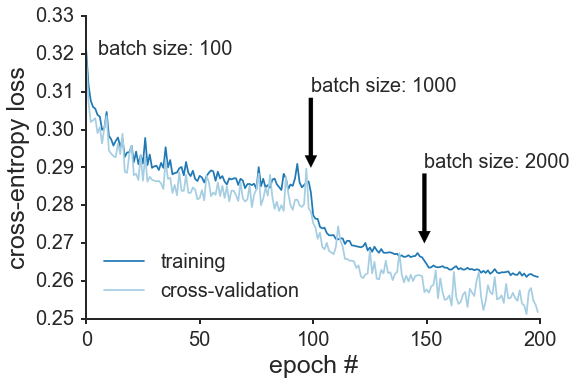

In [90]:
import seaborn as sns
sns.set_style("white", {"xtick.major.size": "5", "ytick.major.size": "5",'axes.linewidth': 2})

plt.plot(train_loss,label='training',color=sns.color_palette("Paired")[1])
plt.plot(valid_loss,label='cross-validation',color=sns.color_palette("Paired")[0])

plt.ylabel('cross-entropy loss',size=25)
plt.xlabel('epoch #',size=25)
ax = plt.gca()
ax.tick_params(width=2,labelsize=20)

ax.annotate('batch size: 1000', size=20,xy=(99, 0.29), xytext=(99, 0.31),
            arrowprops=dict(facecolor='black'))
ax.annotate('batch size: 2000', size=20,xy=(149, 0.27), xytext=(149, 0.29),
            arrowprops=dict(facecolor='black'))

ax.text(5,0.32,'batch size: 100', size=20)

plt.legend(loc=3,fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig('./paper/figure2b.pdf')


# Figure 2c

Plot training & validation PR-AUC and ROC-AUC over epoch

In [83]:
acc_train = np.zeros(train_loss.shape)
pr_train = np.zeros(train_loss.shape)
roc_train = np.zeros(train_loss.shape)

acc_valid = np.zeros(train_loss.shape)
pr_valid = np.zeros(train_loss.shape)
roc_valid = np.zeros(train_loss.shape)

for i in range(len(acc_train)):
    acc_train[i] = sum(np.equal(y_train[:,0],train_pred_lbl[i,:]>=0.5))/train_pred_lbl.shape[1]
    fpr, tpr, thresholds = roc_curve(y_train[:,0],train_pred_lbl[i,:])
    roc_train[i] = auc(fpr,tpr)
    p, r, thresholds = precision_recall_curve(y_train[:,0],train_pred_lbl[i,:])
    pr_train[i] = auc(r,p)
    
    acc_valid[i] = sum(np.equal(y_valid[:,0],valid_pred_lbl[i,:]>=0.5))/valid_pred_lbl.shape[1]
    fpr, tpr, thresholds = roc_curve(y_valid[:,0],valid_pred_lbl[i,:])
    roc_valid[i] = auc(fpr,tpr)
    p, r, thresholds = precision_recall_curve(y_valid[:,0],valid_pred_lbl[i,:])
    pr_valid[i] = auc(r,p)

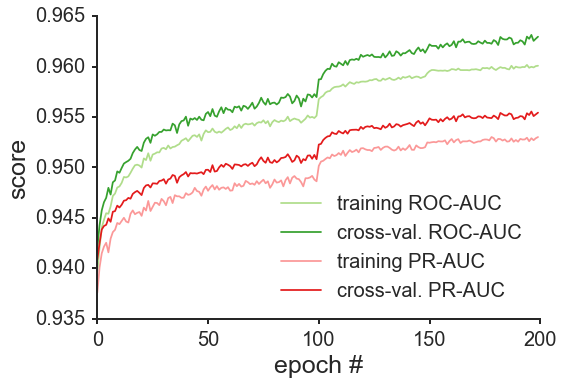

In [94]:
sns.set_style("white", {"xtick.major.size": "5", "ytick.major.size": "5",'axes.linewidth': 2})

plt.plot(roc_train,label='training ROC-AUC',color=sns.color_palette("Paired")[2])
plt.plot(roc_valid,label='cross-val. ROC-AUC',color=sns.color_palette("Paired")[3])
plt.plot(pr_train,label='training PR-AUC',color=sns.color_palette("Paired")[4])
plt.plot(pr_valid,label='cross-val. PR-AUC',color=sns.color_palette("Paired")[5])

plt.ylabel('score',size=25)
plt.xlabel('epoch #',size=25)

ax = plt.gca()
ax.tick_params(width=2,labelsize=20)

plt.legend(loc=4,fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig('./paper/figure2c.pdf')